**Project 1**

**First task**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import invgamma,uniform, norm
import scipy.integrate as integrate

sns.set_context("paper", font_scale=1.5)
sns.set_style("darkgrid")
sns.set_palette("deep")
sns.set(font='sans-serif')
%matplotlib inline
plt.rcParams['figure.dpi'] = 140
import pymc as pm
import arviz as az
import corner

# pymc (>=4)

import pytensor.tensor as tt 
import aesara.tensor as at

print(f'pymc version: {pm.__version__}')
#np.random.seed(123)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc version: 5.18.0


In [2]:
# read the supernova (cosmological) redshift data
datafile = open('Project1/SCPUnion2.1_mu_vs_z.txt','r')
SCP_data = pd.read_table(datafile,comment='#',
                        names=['SN name','Redshift','Distance modulus',
                                   'Distance modulus error','P low mass'])
print(SCP_data)
c = 299792.458 

    SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0    1993ah  0.028488         35.346583                0.223906    0.128419
1    1993ag  0.050043         36.682368                0.166829    0.128419
2     1993o  0.052926         36.817691                0.155756    0.128419
3     1993b  0.070086         37.446737                0.158467    0.128419
4    1992bs  0.062668         37.483409                0.156099    0.128419
..      ...       ...               ...                     ...         ...
575   D-000  1.017000         44.293971                0.171046    0.000015
576   D-006  1.315000         44.971358                0.187509    0.551672
577   P-009  0.821000         43.640939                0.194014    0.551672
578   R-012  1.215000         45.246521                0.560317    0.000148
579   Z-005  0.623000         42.514524                0.241428    0.551672

[580 rows x 5 columns]


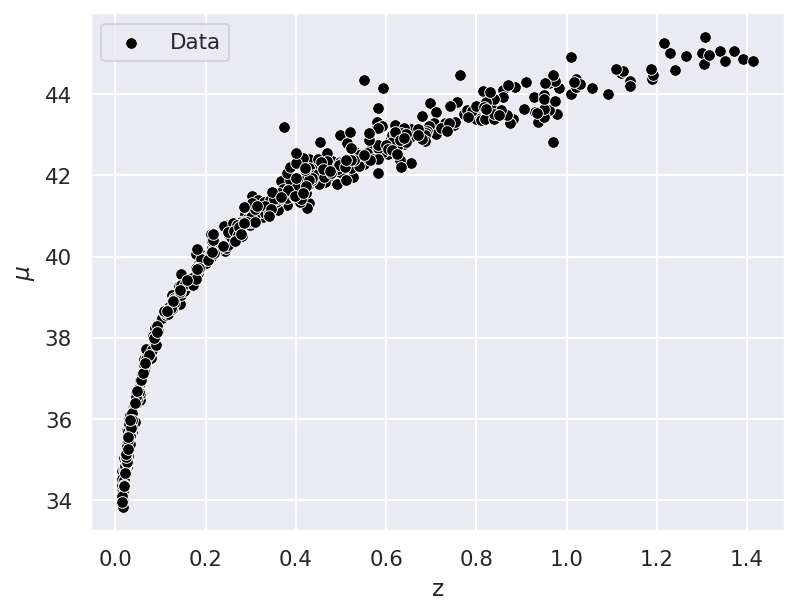

In [3]:
sns.scatterplot(x=SCP_data['Redshift'],y=SCP_data['Distance modulus'],label='Data',color='black');
plt.xlabel('z');
plt.ylabel(f'$\mu$');

In [4]:
dL_z = pm.Model()

with dL_z:

    H_0 = pm.Uniform('H_0',lower=0,upper=100)
    q_0 = pm.Uniform('q_0',lower=-2,upper=2)
    
    alpha = 0.121851859725
    beta = 2.46569277393
    sigma2 = pm.InverseGamma('sigma2',1,1)

    SCP_data_small_z = SCP_data[SCP_data['Redshift'] < 0.5]
    inv_error=1/SCP_data_small_z['Distance modulus error'].to_numpy()#**2
    weights =  len(inv_error)*inv_error/np.sum(inv_error)
    
    z = SCP_data_small_z['Redshift'].to_numpy()
    print(sum(weights))
    print(weights)
    #weights=1
    mu_obs = SCP_data_small_z['Distance modulus'].to_numpy()
    
    mu = 5*np.log10((c/H_0)*(z+0.5*(1-q_0)*z**2))+25
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=np.sqrt(sigma2/weights), observed=mu_obs)

412.00000000000006
[0.75187431 1.00911274 1.08085218 1.06236118 1.0784736  0.89668705
 1.08168734 0.8445445  1.00702906 1.02041366 0.98927085 0.91151664
 1.00606954 0.95919502 1.05369098 0.87997032 1.03724681 0.97145727
 1.17798381 1.13218419 1.8968773  1.64341641 1.57275072 1.55160776
 0.97566759 0.9267126  0.78214846 0.98342241 1.05021766 0.89764766
 1.02483999 1.00276302 0.82135515 0.80371129 0.95455117 0.72423991
 0.67099015 0.72727409 0.7735616  0.69960707 0.61972656 0.74701482
 0.71730042 0.67777456 0.75935463 0.54325477 0.75687556 0.67823635
 0.75032405 0.67023966 1.04271379 1.95537987 2.00072343 1.69877116
 1.50831211 1.07380924 1.30054604 1.93023718 0.81621176 0.91648846
 0.97697141 0.78275983 0.70435611 0.76136325 0.98024315 0.7811716
 0.93414829 0.88623139 0.8095276  0.86991373 0.95248435 0.93462672
 0.69717037 0.79574187 0.94038165 0.91194086 0.96298487 0.79077596
 0.85371126 0.85228759 0.9042574  0.93663906 0.9529815  0.86106499
 0.89300178 0.96077362 0.87467919 0.89360428

In [5]:
map_estimate = pm.find_MAP(model=dL_z)

print(f'According to the Likelihood and Prior defined above, the BFGS optimizer found the following (local) MAP')
H0 = map_estimate['H_0']
q0 = map_estimate['q_0']
s2  = map_estimate['sigma2']

print(f'[H_0,q_0] = [{H0:.3f},{q0:.3f}] and [sigma2] = {s2:.3f}')

/usr/local/lib/python3.10/dist-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


/usr/local/lib/python3.10/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

According to the Likelihood and Prior defined above, the BFGS optimizer found the following (local) MAP
[H_0,q_0] = [69.687,-0.431] and [sigma2] = 0.035


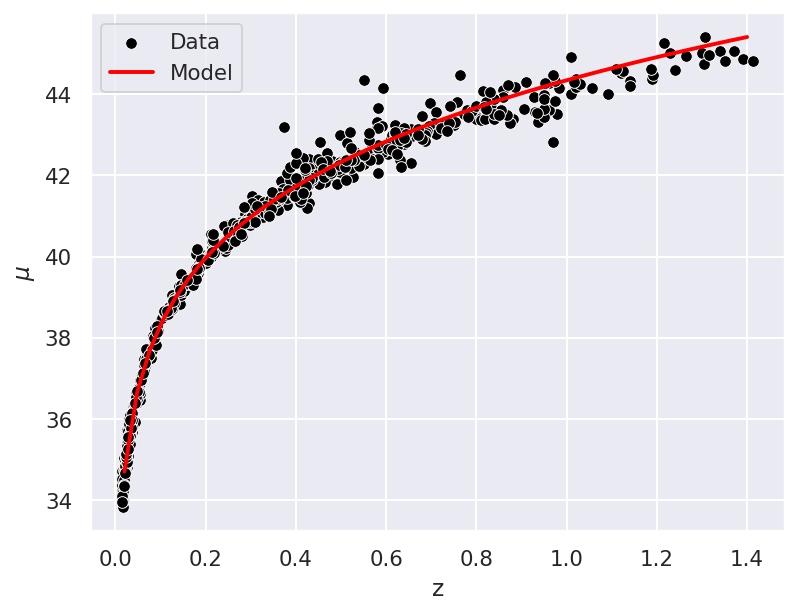

In [6]:
z_array = np.linspace(0.02,1.4)
sns.scatterplot(x=SCP_data['Redshift'],y=SCP_data['Distance modulus'],label='Data',color='black');
sns.lineplot(x=z_array,y=(5*np.log10((c/H0)*(z_array+0.5*(1-q0)*z_array**2))+25),color='red',label='Model',lw=2)
plt.xlabel('z');
plt.ylabel(f'$\mu$');

In [7]:
draws = 2000
chains = 4

with dL_z:
    trace = pm.sample_smc(draws=draws,chains=chains,progressbar=True)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/usr/local/lib/python3.10/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [8]:

with dL_z:
    print(az.summary(trace, kind='stats', round_to=2,hdi_prob=0.9))

         mean    sd  hdi_5%  hdi_95%
H_0     69.69  0.49   68.88    70.50
q_0     -0.43  0.08   -0.56    -0.30
sigma2   0.04  0.00    0.03     0.04


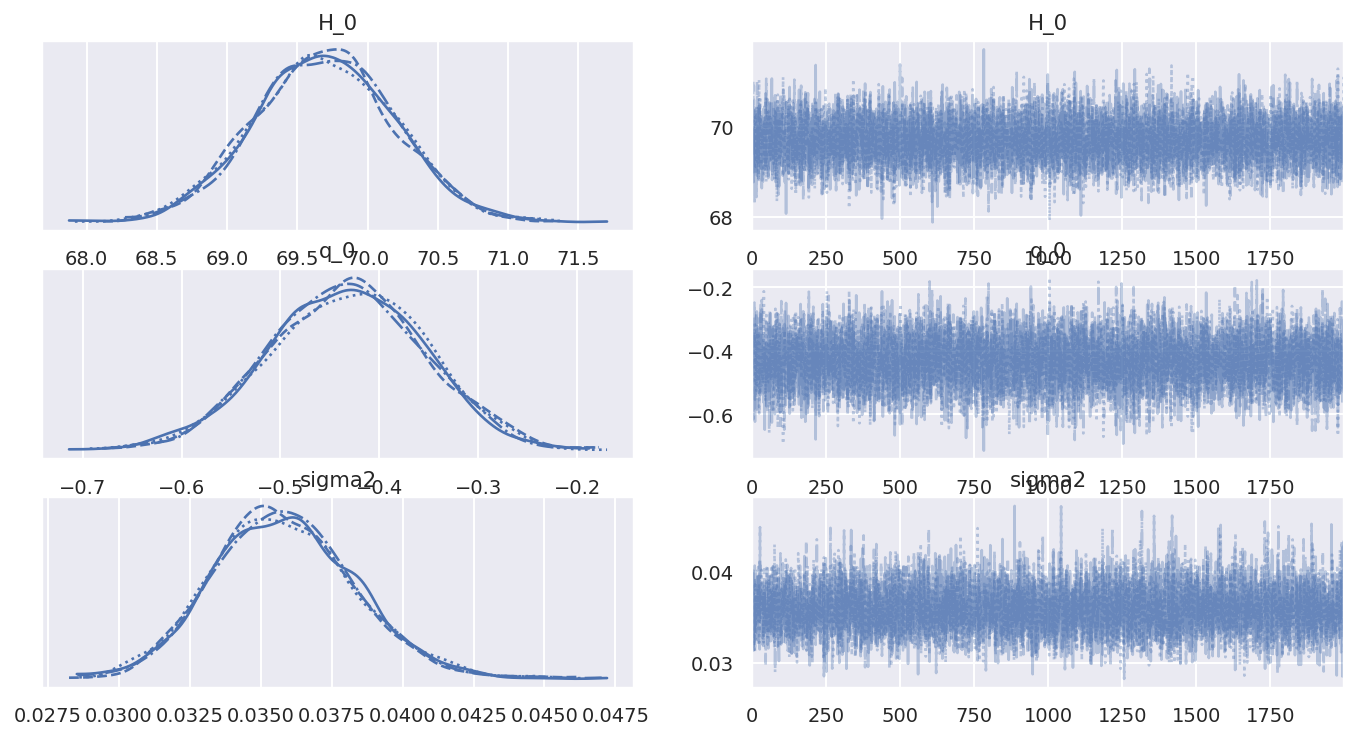

In [9]:

with dL_z:
    az.plot_trace(trace);

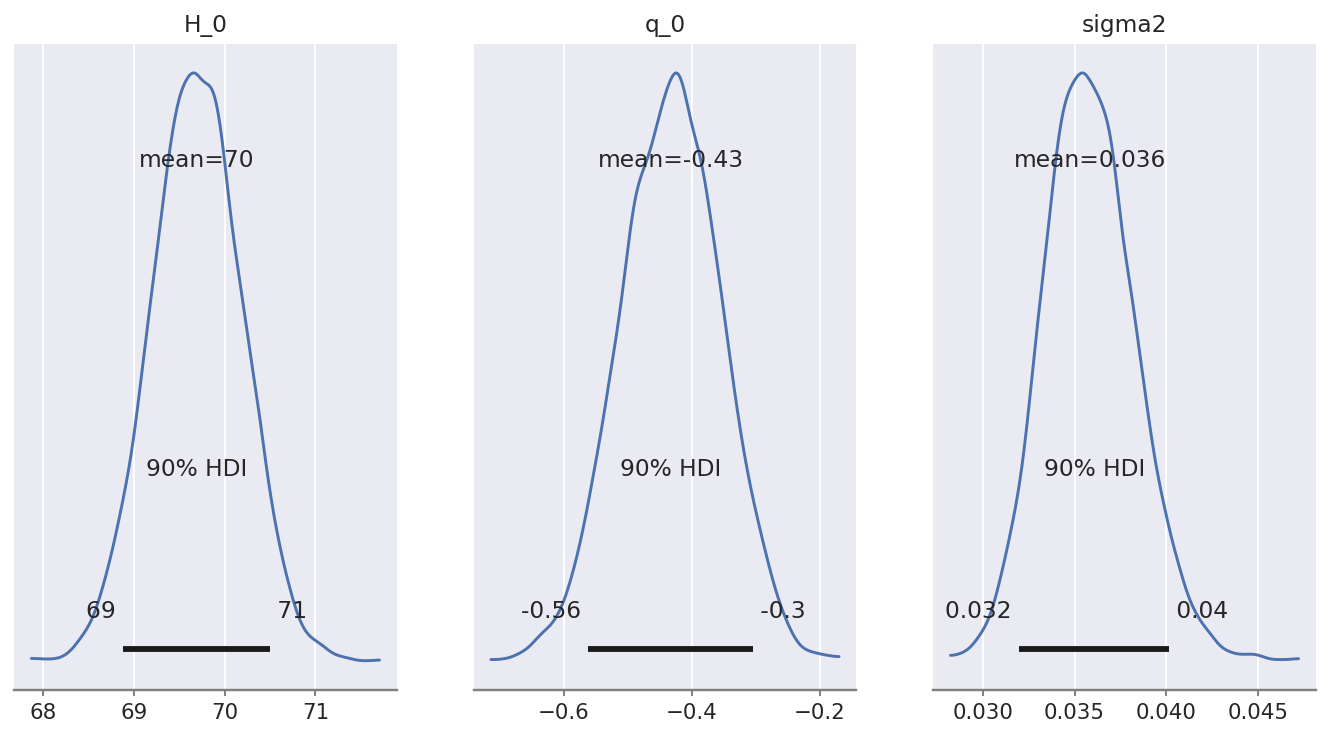

In [10]:
# or plot only marginalized posteriors with some mean and highest_density_intervals
with dL_z:
    az.plot_posterior(trace,figsize=(12, 6),hdi_prob=0.9);

(8000, 1)


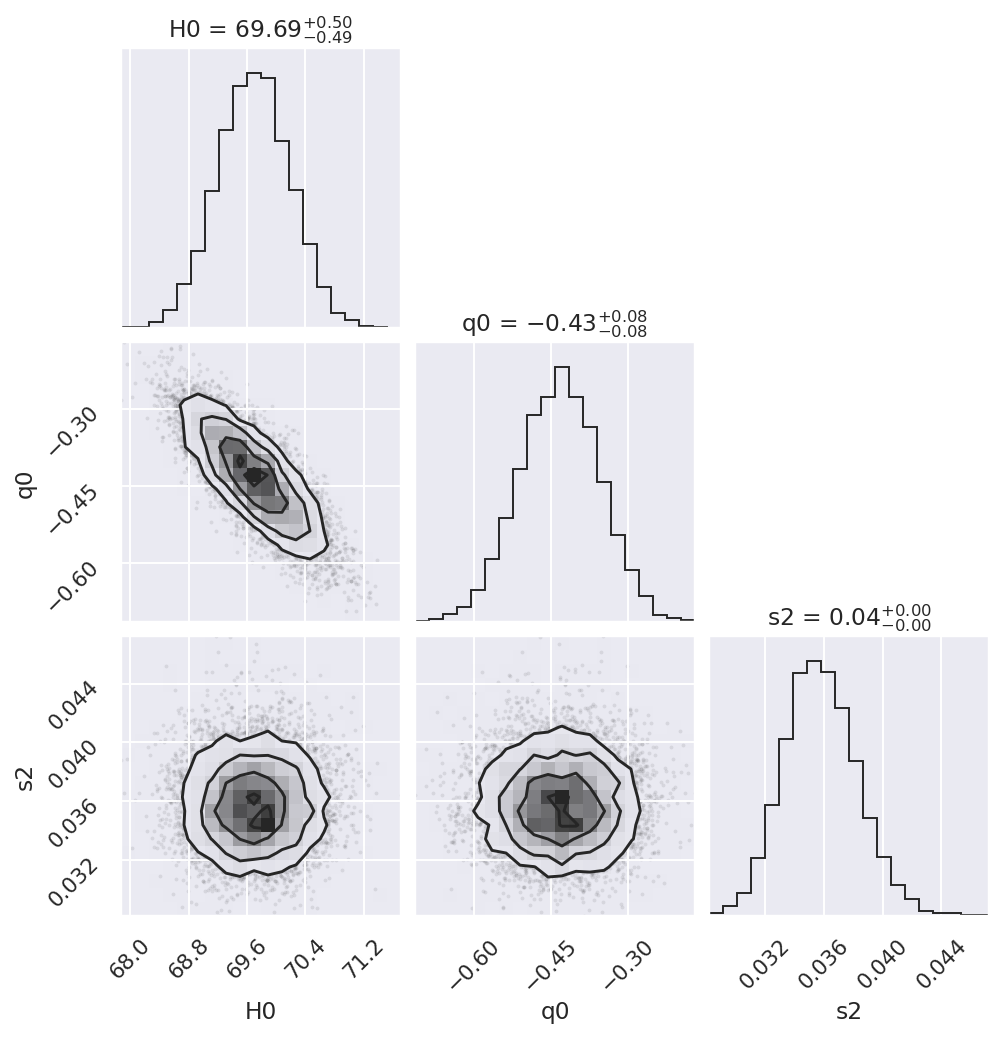

In [11]:
Nsamples = chains * draws
samples_H0 = np.vstack([trace['posterior']['H_0'][:,k] for k in range(0,len(trace['posterior']['H_0'][0]))])
samples_H0 = np.reshape(samples_H0,(Nsamples,1))

samples_q0 = np.vstack([trace['posterior']['q_0'][:,k] for k in range(0,len(trace['posterior']['q_0'][0]))])
samples_q0 = np.reshape(samples_q0,(Nsamples,1))

samples_s2 = np.vstack([trace['posterior']['sigma2'][:,k] for k in range(0,len(trace['posterior']['sigma2'][0]))])
samples_s2 = np.reshape(samples_s2,(Nsamples,1))

print(samples_H0.shape)

samples = np.hstack((samples_H0,np.hstack((samples_q0,samples_s2))))
fig_corner = corner.corner(samples,labels =['H0','q0','s2'],show_titles=True);

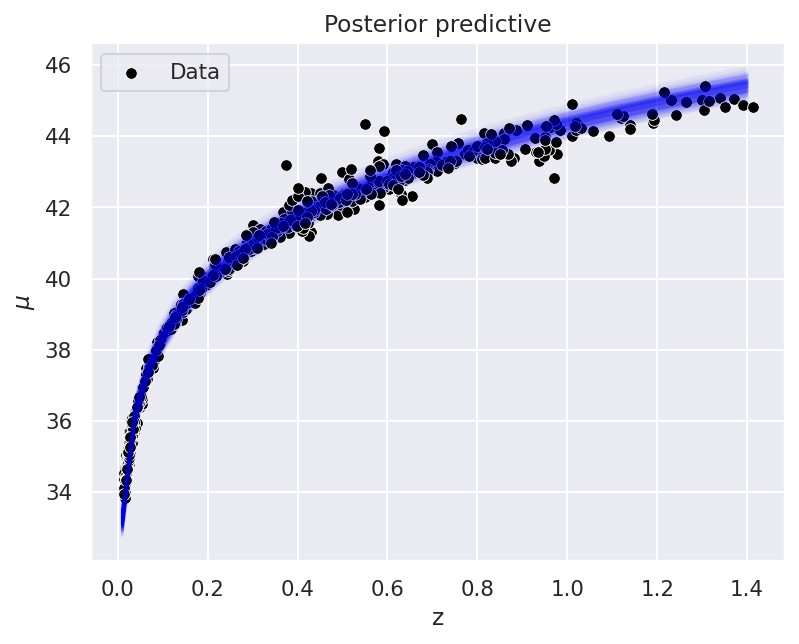

In [12]:
N=500
z_a = np.linspace(0.01,1.4)
sns.scatterplot(x=SCP_data['Redshift'],y=SCP_data['Distance modulus'],label='Data',color='black');
for sample in range(0,N):
    epsilon = np.random.normal(scale=np.sqrt(samples_s2[sample]))
    mu = 5*np.log10((c/samples_H0[sample])*(z_a+0.5*(1-samples_q0[sample])*z_a**2))+25+epsilon
    plt.plot(z_a,mu,color='blue',alpha=0.01)


plt.xlabel('z');
plt.ylabel(f'$\mu$');
plt.title("Posterior predictive");

**Task 2**

In [13]:
H_0_calibrated = 70

**$\Lambda$CDM**

In [14]:
import scipy.optimize as opt

mu_obs_data = SCP_data['Distance modulus'].to_numpy()
z_data = SCP_data['Redshift'].to_numpy()

dz = (max(z_data)-min(z_data))/len(z)

def H_inv_lambda(z,Omega_M_0):
    Omega_lambda_0 = 1 - Omega_M_0
    E = Omega_M_0*(1+z)**3+Omega_lambda_0
    H = H_0_calibrated*np.sqrt(E)
    return 1/H


def mu_f_lambda(Omega_M_0,z):
    z_array = np.linspace(0,z,1000)
    d_L = c*(1+z)*np.trapz(H_inv_lambda(z_array,Omega_M_0),z_array)
    mu = 5*np.log10(d_L)+25
    return mu



def log_likelihood_minus_lambda(Omega_M_0,mu_obs,z,sigma2):
    
    ll_sum = 0    
    for i in range(len(z)):
            ll_sum += ((mu_f_lambda(Omega_M_0,z[i])-mu_obs[i])**2/sigma2[i])
    return ll_sum 
    
Omega_M_0_guess = 0.5 
inv_error=1/SCP_data['Distance modulus error'].to_numpy()
weights =  len(inv_error)*inv_error/np.sum(inv_error)
sigma2_data = 1/weights

result = opt.minimize(log_likelihood_minus_lambda, Omega_M_0_guess, args=(mu_obs_data, z_data, sigma2_data), bounds=[(0, 1.0)])
print(f"Best-fit Omega_M_0: {result.x[0]}") 
Omega_star = result.x[0]

Best-fit Omega_M_0: 0.2684510129642277


In [15]:
N_p = 1
N_d = len(z_data)
def log_likelihood_lambda(Omega_M_0,mu_obs,z,sigma2):
    
    ll_sum = 0    
    for i in range(len(z)):
            ll_sum += -(0.5*((mu_f_lambda(Omega_M_0,z[i])-mu_obs[i])**2/sigma2[i]))
    return ll_sum 

mle = log_likelihood_lambda(Omega_star,mu_obs_data,z_data,sigma2_data)


#AIC
AIC = 2*mle - 2*N_p
print(AIC)

#BIC


BIC = 2*mle- N_p*np.log(N_d)
print(BIC)

-25.961628614856696
-30.32465671839716


**wCDM**

In [16]:
import scipy.optimize as opt
    
def H_inv_w(z,Omega_M_0,w):
    Omega_lambda_0 = 1 - Omega_M_0
    E = Omega_M_0*(1+z)**3+Omega_lambda_0*(1+z)**(3*(1+w))
    H = H_0_calibrated*np.sqrt(E)
    return 1/H

def mu_f_w(Omega_M_0,w,z):
    z_array = np.linspace(0,z,1000)
    d_L = c*(1+z)*np.trapz(H_inv_w(z_array,Omega_M_0,w),z_array)
    mu = 5*np.log10(d_L)+25
    return mu



def log_likelihood_minus_w(parameters,mu_obs,z,sigma2):
    [Omega_M_0, w] = parameters 
    ll_sum = 0    
    for i in range(len(z)):
            ll_sum += ((mu_f_w(Omega_M_0,w,z[i])-mu_obs[i])**2/sigma2[i])        
    return ll_sum 
    
    #np.sum((mu_f(Omega_M_0,z) - mu_obs)**2/sigma2)
    
Omega_M_0_guess = 0.5
w_guess = 0.5

result = opt.minimize(log_likelihood_minus_w, [Omega_M_0_guess, w_guess], args=(mu_obs_data, z_data, sigma2_data), bounds=[(0, 1.0), (-10,10)])
print(f"Best-fit Omega_M_0, w: {result.x[0], result.x[1]}") 
Omega_star = result.x[0]
w_star = result.x[1] 

Best-fit Omega_M_0, w: (0.3069611839690991, -1.100992767378343)


In [17]:
def log_likelihood_w(Omega_M_0,w,mu_obs,z,sigma2): 
    ll_sum = 0    
    for i in range(len(z)):
            ll_sum += -0.5*((mu_f_w(Omega_M_0,w,z[i])-mu_obs[i])**2/sigma2[i])
    #ll_sum += np.log((1/(2*np.pi*sigma2[i]))**(N_d*0.5)) 
    #np.log((1/(2*np.pi*sigma2[i]))**(0.5))        
    return ll_sum 

mle = log_likelihood_w(Omega_star,w_star,mu_obs_data,z_data,sigma2_data)
N_p = 2
N_d = len(z_data)

#AIC
AIC = 2*mle- 2*N_p
print(AIC)

#BIC

BIC = 2*mle- N_p*np.log(N_d)
print(BIC)

-27.9454772664054
-36.671533473486335


In [ ]:
import emcee

# Define the posterior (log-likelihood + optional priors)
def log_posterior(Omega_M_0, mu_obs, z, sigma2):
    # Flat prior: uniform in [0, 1], return -inf for invalid values
    if not (0.0 <= Omega_M_0 <= 1.0):
        return -np.inf
    # Negative log-likelihood
    return -log_likelihood_minus_lambda(Omega_M_0, mu_obs, z, sigma2)

# Number of dimensions (1 parameter: Omega_M_0)
ndim = 1
# Number of walkers and steps
nwalkers = 4
nsteps = 2000

# Initialize walkers near the best-fit value
initial_pos = result.x[0] + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(mu_obs_data, z_data, sigma2_data)
)

# Run MCMC
print("Running MCMC...")
sampler.run_mcmc(initial_pos, nsteps, progress=True)

Running MCMC...


 15%|█▌        | 300/2000 [01:12<06:51,  4.13it/s]

In [ ]:
# Extract samples
samples = sampler.get_chain(flat=True)
std = np.std(samples)
mean = np.mean(samples)
# Plot the posterior distribution
plt.hist(samples, bins=30, density=True, alpha=0.7, label=r"$\Omega_{M,0}$")
plt.axvline(mean, color="red", linestyle="-", label="Mean")
plt.axvline(mean + std, color="red", linestyle="--", label=r"$1\sigma$")
plt.axvline(mean - std, color="red", linestyle="--")#, label=r"$-\sigma$")
plt.axvline(mean + 2*std, color="red", linestyle=":", label=r"$2\sigma$")
plt.axvline(mean - 2*std, color="red", linestyle=":")#, label=r"$-\sigma$")

plt.xlabel(r"$\Omega_{M,0}$")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

# Use corner to visualize posterior
fig = corner.corner(samples, labels=[r"$\Omega_{M,0}$"], truths=[result.x[0]])

plt.show()

In [ ]:
# Extract the chain (nwalkers, nsteps, ndim)
chain = sampler.get_chain()

# Plot trace for each walker
plt.figure(figsize=(6,5))
for i in range(chain.shape[1]):  # Loop over walkers
    print(i)
    plt.plot(chain[:, i, 0], alpha=0.5, label=r"Walker "+str(i+1))  # Plot Omega_M_0 (parameter index 0)
plt.xlabel("Step number")
plt.ylabel(r"$\Omega_{M,0}$")
plt.title("Trace Plot for Walkers")
plt.legend()
plt.show()